# Google Analytics Customer Revenue Prediction
Presenting the initial data:
* Data Fields: fullVisitorIdv - A unique identifier for each user of the Google Merchandise Store. 
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

First of all, the data are becoming in Json format, so we will need to handle with it and I will use a chunk that I saw in almost all kernel of this competition.

Objectives:
* I will explore if we have some difference between the browser and if browser is significant to predict sells. 
* Which countrys and continents have more acesses and sales ? How it's distributed?! 
* Which type of device are most normal in our dataset?
* What's the mobile % of accesses? 
* Which is the most frequent Operational System? 
* What's the most frequent channelGrouping ?
* Whats the most frequent Weekdays, months, days, year with highest accesses and revenue?
* And another bunch of ideas that I will have when start exploring.

# Importing necessary librarys

In [1]:
import random
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import json
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', 1000)

plt.style.use('fivethirtyeight')
init_notebook_mode(connected=True)

# Some columns are in Json format so it will be necessary to handle with this problem.
I will use a chunk code inspiration that almost all kernels are using I dont know who did first, but I got on SRK kernel and I did some modifications

In [51]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] # Columns that have json format

dir_path = "" # you can change to your local 

# p is a fractional number to skiprows and read just a random sample of the our dataset. 
p = 0.07 # *** In this case we will use 50% of data set *** #

#Code to transform the json format columns in table
def json_read(df):
    #joining the [ path + df received]
    data_frame = dir_path + df
    
    #Importing the dataset
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, # loading the json columns properly
                     dtype={'fullVisitorId': 'str'}, # transforming this column to string
                     skiprows=lambda i: i>0 and random.random() > p)# Number of rows that will be imported randomly
    
    for column in columns: #loop to finally transform the columns in data frame
        #It will normalize and set the json to a table
        column_as_df = json_normalize(list(df[column]))
        # here will be set the name using the category and subcategory of json columns
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        # after extracting the values, let drop the original columns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df # returning the df after importing and transforming

# Importing the datasets

In [52]:
%%time 
# %%time is used to calculate the timing of code chunk execution #

# We will import the data using the name and extension that will be concatenated with dir_path
df_train = json_read("train.csv") 
# The same to test dataset
#df_test = json_read("test.csv") 

Wall time: 16.6 s


Nice. 
After the import and transformation, we have 54 columns. 
Now, let's see our data and handle with problemns that we will find

In [53]:
# This command shows the first 5 rows of our dataset
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,0523069750702990437,0523069750702990437_1472834967,Not Socially Engaged,1472834967,1,1472834967,Chrome,not available in demo dataset,not available in demo dataset,tablet,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,India,not available in demo dataset,not available in demo dataset,not available in demo dataset,airtelbroadband.in,not available in demo dataset,not available in demo dataset,Southern Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,3982295596181714479,3982295596181714479_1472825889,Not Socially Engaged,1472825889,1,1472825889,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Taiwan,not available in demo dataset,not available in demo dataset,not available in demo dataset,hinet.net,not available in demo dataset,not available in demo dataset,Eastern Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,0715569826025005549,0715569826025005549_1472864193,Not Socially Engaged,1472864193,1,1472864193,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Santiago,not available in demo dataset,Americas,Chile,not available in demo dataset,not available in demo dataset,(not set),movistar.cl,not available in demo dataset,Santiago Metropolitan Region,South America,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4293186657068577544,4293186657068577544_1472810795,Not Socially Engaged,1472810795,1,1472810795,Chrome,not available in demo dataset,not available in demo dataset,desktop,not availab

# Knowing the missing values

In [54]:
# code chunk that I saw in Gabriel Preda kernel
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((df_train[df_train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(df_train['totals.transactionRevenue']) * 100),4))
    
    return 

In [55]:
# calling the missing values function
missing_values(df_train) 

Total columns at least one Values: 
                                              Total    Percent
trafficSource.adContent                       62219  98.824632
totals.transactionRevenue                     62172  98.749980
trafficSource.adwordsClickInfo.adNetworkType  61495  97.674677
trafficSource.adwordsClickInfo.slot           61495  97.674677
trafficSource.adwordsClickInfo.page           61495  97.674677
trafficSource.adwordsClickInfo.isVideoAd      61495  97.674677
trafficSource.adwordsClickInfo.gclId          61483  97.655617
trafficSource.isTrueDirect                    44014  69.908988
trafficSource.referralPath                    39885  63.350752
trafficSource.keyword                         35177  55.872870
totals.bounces                                31412  49.892787
totals.newVisits                              13826  21.960323
totals.pageviews                                  6   0.009530

 Total of Sales % of Total:  1.25


Nice. We can see that we have: 

* Our target have just 1.3% of non-null values 
* 6 columns with 97%+ of missing values 
* 4 columns with 50%+ of missing values 
* 1 column with 22.22% 
* 1 column with 0.004% 

We will explore to understand what it looks like

Let's take a look on datatypes of all columns

In [56]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62959 entries, 0 to 62958
Data columns (total 54 columns):
channelGrouping                                      62959 non-null object
date                                                 62959 non-null int64
fullVisitorId                                        62959 non-null object
sessionId                                            62959 non-null object
socialEngagementType                                 62959 non-null object
visitId                                              62959 non-null int64
visitNumber                                          62959 non-null int64
visitStartTime                                       62959 non-null int64
device.browser                                       62959 non-null object
device.browserSize                                   62959 non-null object
device.browserVersion                                62959 non-null object
device.deviceCategory                                62959 non-null ob

Nice!
Data Types contained in our dataframe: 

* bool(1) 
* int64(4) 
* object(49) 

# Creating the function to handle with date

In [57]:
# library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [58]:
df_train = date_process(df_train) #calling the function that we created above

df_train.head(n=2) #printing the first 2 rows of our dataset

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2016-09-02,0523069750702990437,0523069750702990437_1472834967,Not Socially Engaged,1472834967,1,1472834967,Chrome,not available in demo dataset,not available in demo dataset,tablet,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,India,not available in demo dataset,not available in demo dataset,not available in demo dataset,airtelbroadband.in,not available in demo dataset,not available in demo dataset,Southern Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,4,2,9,2016,12
1,Organic Search,2016-09-02,3982295596181714479,3982295596181714479_1472825889,Not Socially Engaged,1472825889,1,1472825889,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,Taiwan,not available in demo dataset,not available in demo dataset,not available in demo dataset,hinet.net,not available in demo dataset,not available in demo dataset,Eastern Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,4,2,9,2016,10


Before look the unique values in each column, I will drop the constant values that is not useful and will make the df lighter

In [59]:
def FillingNaValues(df):    # fillna numeric feature
    df['totals.pageviews'].fillna(1, inplace=True).astype(int) #filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True).astype(int) #filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True).astype(int)   #filling NA's with 0
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float) #filling NA with zero
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    df_train.loc[df_train['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
    df_train['geoNetwork.city'].fillna("NaN", inplace=True)

    return df #return the transformed dataframe

In [60]:
def NumericalColumns(df):    # fillna numeric feature
    df['totals.pageviews'].fillna(1, inplace=True) #filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True) #filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True)   #filling NA's with 0
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float) #filling NA with zero
    df['totals.pageviews'] = df['totals.pageviews'].astype(int) # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int) # setting numerical column as integer
    df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float) # setting numerical to float
    df['totals.visits'] = df['totals.visits'].astype(int) # seting as int

    return df #return the transformed dataframe

In [61]:
from sklearn import preprocessing

def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    df['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df 

Let's investigate some constant columns

In [62]:
# We will takeoff all columns where we have a unique value (constants)
# It is useful because this columns don't give us none information
discovering_consts = [col for col in df_train.columns if df_train[col].nunique() == 1]

# printing the total of columns dropped and the name of columns 
print("Columns with just one value: ", len(discovering_consts), "columns")
print("Name of constant columns: \n", discovering_consts)

Columns with just one value:  24 columns
Name of constant columns: 
 ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.bounces', 'totals.newVisits', 'totals.visits', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']


In [63]:
#Here are all columns that the unique value is 'not available in demo dataset'

not_aval_cols = ['socialEngagementType','device.browserSize','device.browserVersion', 'device.flashVersion', 
                 'device.language' ,'device.mobileDeviceBranding', 'device.mobileDeviceInfo','device.mobileDeviceMarketingName',
                 'device.mobileDeviceModel', 'device.mobileInputSelector' , 'device.operatingSystemVersion','device.screenColors',
                 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude' ,'geoNetwork.longitude',
                 'geoNetwork.networkLocation','trafficSource.adwordsClickInfo.criteriaParameters']

# It's useul to we have notion that might we have 23 constant columns
Below I will set a function to better investigate our data and correctly categorize them

In [65]:
# seting the function to show 
def knowningData(df, data_type=object, limit=3): #seting the function with df, 
    n = df.select_dtypes(include=data_type) #selecting the desired data type
    for column in n.columns: #initializing the loop
        print("##############################################")
        print("Name of column ", column, ': \n', "Uniques: ", df[column].unique()[:limit], "\n",
              " | ## Total nulls: ", (round(df[column].isnull().sum() / len(df[column]) * 100,2)),
              " | ## Total unique values: ", df_train.nunique()[column]) #print the data and % of nulls)
        # print("Percentual of top 3 of: ", column)
        # print(round(df[column].value_counts()[:3] / df[column].value_counts().sum() * 100,2))
        print("#############################################")

In [66]:
# calling our function: object is default
knowningData(df_train)

##############################################
Name of column  channelGrouping : 
 Uniques:  ['Organic Search' 'Affiliates' 'Referral'] 
  | ## Total nulls:  0.0  | ## Total unique values:  8
#############################################
##############################################
Name of column  fullVisitorId : 
 Uniques:  ['0523069750702990437' '3982295596181714479' '0715569826025005549'] 
  | ## Total nulls:  0.0  | ## Total unique values:  60517
#############################################
##############################################
Name of column  sessionId : 
 Uniques:  ['0523069750702990437_1472834967' '3982295596181714479_1472825889'
 '0715569826025005549_1472864193'] 
  | ## Total nulls:  0.0  | ## Total unique values:  62955
#############################################
##############################################
Name of column  socialEngagementType : 
 Uniques:  ['Not Socially Engaged'] 
  | ## Total nulls:  0.0  | ## Total unique values:  1
#######################

Name of column  totals.visits : 
 Uniques:  ['1'] 
  | ## Total nulls:  0.0  | ## Total unique values:  1
#############################################
##############################################
Name of column  trafficSource.adContent : 
 Uniques:  [nan '{KeyWord:Google Brand Items}' 'Full auto ad IMAGE ONLY'] 
  | ## Total nulls:  98.82  | ## Total unique values:  28
#############################################
##############################################
Name of column  trafficSource.adwordsClickInfo.adNetworkType : 
 Uniques:  [nan 'Google Search'] 
  | ## Total nulls:  97.67  | ## Total unique values:  1
#############################################
##############################################
Name of column  trafficSource.adwordsClickInfo.criteriaParameters : 
 Uniques:  ['not available in demo dataset'] 
  | ## Total nulls:  0.0  | ## Total unique values:  1
#############################################
##############################################
Name of column  traff

In [67]:
knowningData(df_train, data_type=int)

##############################################
Name of column  _visitHour : 
 Uniques:  [12 10 20] 
  | ## Total nulls:  0.0  | ## Total unique values:  24
#############################################


In [68]:
knowningData(df_train, data_type=float)

# I will drop some of this features and fillna or missing in some of them

In [69]:
to_drop = ["socialEngagementType",'device.browserVersion', 'device.browserSize', 'device.flashVersion', 'device.language', 
           'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel',
           'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 
           'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude','geoNetwork.networkLocation', 
           'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.campaign',
           'trafficSource.adwordsClickInfo.page', 'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.slot',
           'trafficSource.adContent', 'trafficSource.keyword']

In [70]:
df_train.drop(to_drop, axis=1, inplace=True)

In [71]:
print("Total features dropped: ", len(to_drop))
print("Shape after dropping: ", df_train.shape)

Total features dropped:  25
Shape after dropping:  (62959, 34)


In [72]:
# call the function to transform the numerical columns
df_train = NumericalColumns(df_train)

# Call the function that will normalize some features
df_train = Normalizing(df_train)

In [73]:
# We will takeoff all columns where we have a unique value
# It is useful because this columns don't give us none information
clean_consts = [col for col in df_train.columns if df_train[col].nunique() == 1]


# this function drop all constant columns, inplacing the data 
df_train.drop('trafficSource.adwordsClickInfo.adNetworkType', axis=1, inplace=True) 

# printing the total of columns dropped and the name of columns 
print("This useful action will drop: ", len(clean_consts), "columns")
print("All dropped columns: \n", clean_consts)

This useful action will drop:  2 columns
All dropped columns: 
 ['totals.visits', 'trafficSource.adwordsClickInfo.adNetworkType']


In [74]:
df_train.nunique()

channelGrouping                                 8
date                                          366
fullVisitorId                               60517
sessionId                                   62955
visitId                                     62870
visitNumber                                   186
visitStartTime                              62875
device.browser                                 25
device.deviceCategory                           3
device.isMobile                                 2
device.operatingSystem                         16
geoNetwork.city                               489
geoNetwork.continent                            6
geoNetwork.country                            178
geoNetwork.metro                               75
geoNetwork.networkDomain                     5701
geoNetwork.region                             315
geoNetwork.subContinent                        23
totals.bounces                                  2
totals.hits                                   151


Excellent. Now we don't have more constant values

Based on this output I will select and set a variable with all features by category

In [76]:
dummy_feaures =['channelGrouping', 'device.browser', 'device.deviceCategory', 'geoNetwork.city', 'device.operatingSystem', 
                'trafficSource.medium', 'trafficSource.source',
                'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 
                'geoNetwork.subContinent']

numericals = ['totals.visits', '_visitHour', '_day', '_month', '_weekday']

# First, let see the distribuition of transactions Revenues
I will start exploring the quantile

Transaction Revenue Min Value:  13.579789490265188
Transaction Revenue Mean Value:  17.833301759426266
Transaction Revenue Median Value:  17.766177206226494
Transaction Revenue Max Value:  23.605577421017145


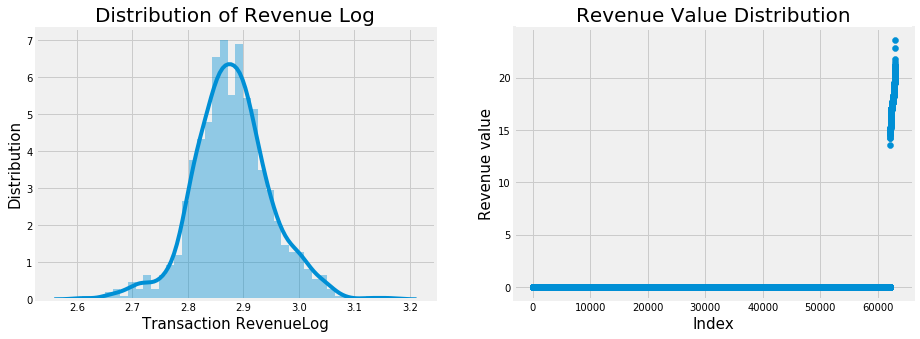

In [79]:
# Printing some statistics of our data
print("Transaction Revenue Min Value: ", 
      df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].min()) # printing the min value
print("Transaction Revenue Mean Value: ", 
      df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].mean()) # mean value
print("Transaction Revenue Median Value: ", 
      df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].median()) # median value
print("Transaction Revenue Max Value: ", 
      df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].max()) # the max value


plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(np.log(df_train[df_train['totals.transactionRevenue']>0]['totals.transactionRevenue'] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize=15)
ax.set_ylabel('Distribution', fontsize=15)
ax.set_title('Distribution of Revenue Log', fontsize=20)

plt.subplot(1,2,2)
plt.scatter(range(df_train.shape[0]), np.sort(df_train['totals.transactionRevenue'].values))
plt.xlabel('Index', fontsize=15) 
plt.ylabel('Revenue value', fontsize=15) 
plt.title("Revenue Value Distribution", fontsize=20) 

plt.show()

Nice distribuition... We have very high values on the Transactions Revenues

# I will see the kurtosis and Skewness of Transaction Revenue
Skew and Kurtosis: 2 Important Statistics terms you need to know

* Skewness
It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution.
It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0.

* Positive Skewness means when the tail on the right side of the distribution is longer or fatter. The mean and median will be greater than the mode.
* Negative Skewness is when the tail of the left side of the distribution is longer or fatter than the tail on the right side. The mean and median will be less than the mode.

So, when is the skewness too much?
The rule of thumb seems to be:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. 

If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.

If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.

# Kurtosis
Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. 
It is actually the measure of outliers present in the distribution.

* High kurtosis in a data set is an indicator that data has heavy tails or outliers. If there is a high kurtosis, then, we need to investigate why do we have so many outliers. It indicates a lot of things, maybe wrong data entry or other things. Investigate! 
* Low kurtosis in a data set is an indicator that data has light tails or lack of outliers. If we get low kurtosis(too good to be true), then also we need to investigate and trim the dataset of unwanted results

In [84]:
print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])))
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))))

Excess kurtosis of normal distribution (should be 0): 1.2341134603260597
Skewness of normal distribution (should be 0): 0.3611708746580635


Our data are fairly symmetrical skewed and have a High Kurtosis.

I will see how many outliers we have on this dataset.

In [85]:
def CalcOutliers(df_num):
    
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    
    # seting the cut line to both higher and lower values
    # you can change this value
    
    cut = data_std * 3
    
    lower, upper = data_mean - cut, data_mean + cut
    
    # creating an array of lower, higher and total outliers values
    outliers_lower = [x for x in df_num if x<lower]
    outliers_higher = [x for x in df_num if x>upper]
    outliers_total = [x for x in df_num if x<lower or x>upper]
    
    # array without outliers values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers : ', len(outliers_lower))
    print('Identified upper outliers : ', len(outliers_higher))
    print('Identified outliers : ', len(outliers_total))
    print('None-outlier observations : ', len(outliers_removed))
    print('Total percentual of outliers : ', round((len(outliers_total)/len(outliers_removed))*100, 4))
    
    return

In [87]:
CalcOutliers(df_train['totals.transactionRevenue'])

Identified lowest outliers :  0
Identified upper outliers :  787
Identified outliers :  787
None-outlier observations :  62172
Total percentual of outliers :  1.2658


In [88]:
CalcOutliers(df_train['totals.pageviews'])

Identified lowest outliers :  0
Identified upper outliers :  1183
Identified outliers :  1183
None-outlier observations :  61776
Total percentual of outliers :  1.915


# Device Browsers

Percentual of Browser usage : 
Chrome               43061
Safari               12771
Firefox               2622
Internet Explorer     1385
Edge                   681
Android Webview        579
Safari (in-app)        494
Name: device.browser, dtype: int64


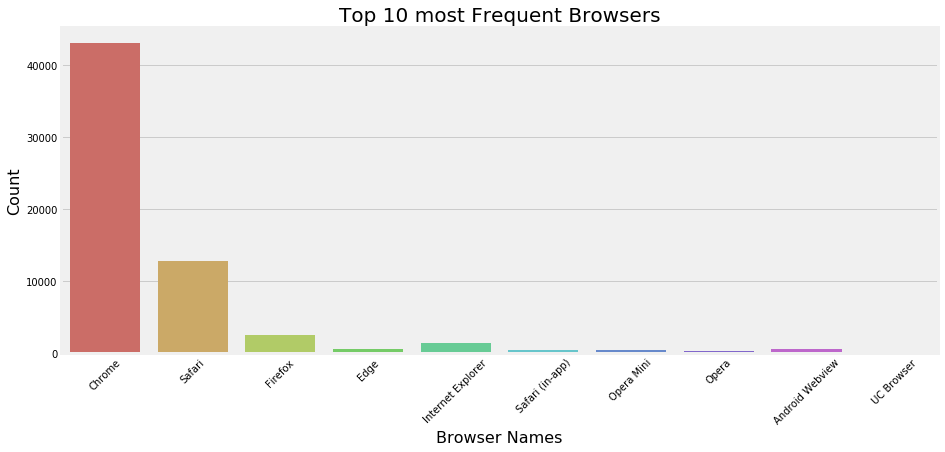

In [90]:
print('Percentual of Browser usage : ')
print(df_train['device.browser'].value_counts()[:7])

plt.figure(figsize=(14,6))
sns.countplot(df_train[df_train['device.browser'].isin(df_train['device.browser'].value_counts()[:10].index.values)]['device.browser'], palette='hls')
plt.title('Top 10 most Frequent Browsers', fontsize=20)
plt.xlabel('Browser Names', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In our top 5 browsers we have more than 94% of total
* TOP 1 - CHROME - 69,08%
* TOP 2 - SAFARI - 20,04%
* TOP 3 - FIREFOX - 3,77%
Nothing new under the sun... Chrome is the most used followed by Safari and firefox.

# What if we cross the Revenue and Browser?

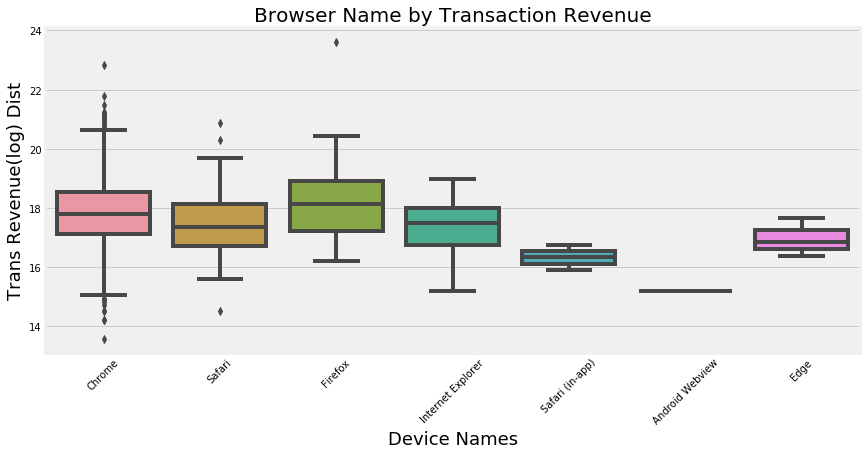

In [94]:
plt.figure(figsize=(13,6))

sns.boxplot(x='device.browser', y='totals.transactionRevenue', data=df_train[(df_train['device.browser'].isin((df_train['device.browser'].value_counts()[:10].index.values))) & df_train['totals.transactionRevenue']>0])
plt.title('Browser Name by Transaction Revenue', fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Device Names', fontsize=18)
plt.ylabel('Trans Revenue(log) Dist', fontsize=18)
plt.show()

I think that it's very insightful information.

Chrome have highest values in general but the highest value of transactions was did on Firefox.
We can see a "small" but consistent sells in Safari. Also IE and Edge give some results to Google;

# Let's see the channel Grouping
* The channel via which the user came to the store

Percentual of channel grouping used : 
Organic Search    26519
Social            15747
Direct            10020
Referral           7327
Paid Search        1726
Name: channelGrouping, dtype: int64


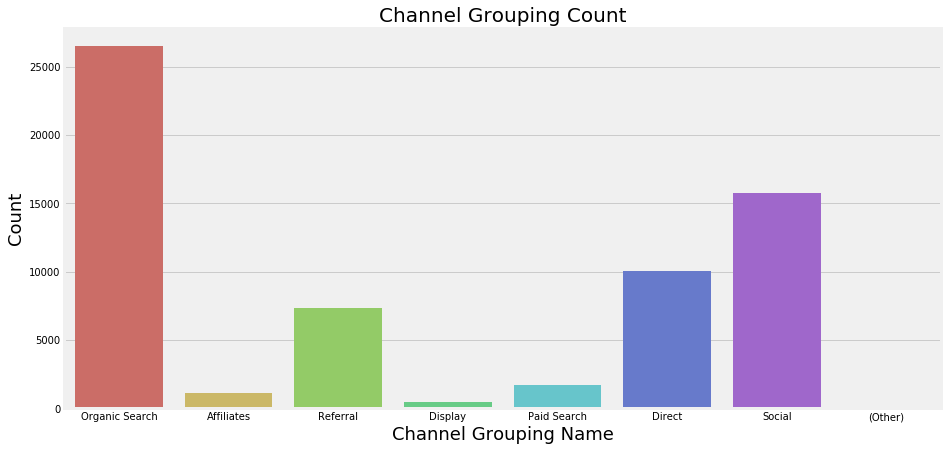

In [101]:
print('Percentual of channel grouping used : ')
print((df_train['channelGrouping'].value_counts()[:5]))
plt.figure(figsize=(14,7))
sns.countplot(df_train['channelGrouping'], palette='hls')
plt.title('Channel Grouping Count', fontsize=20)
plt.xlabel('Channel Grouping Name', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

The TOP 5 Grouping Channels represents 97% of total values. Respectivelly:

* TOP 1 => Organic Search - 42.99%
* TOP 2 => Social - 24.39%
* TOP 3 => Direct - 15.42%
* TOP 4 => Referral - 11.89%
* TOP 5 => Paid Search - 2.55%
I have a new insight that I will explore furthuer. How wich channel are distributed by browsers?

# Crossing Channel Grouping x Browsers

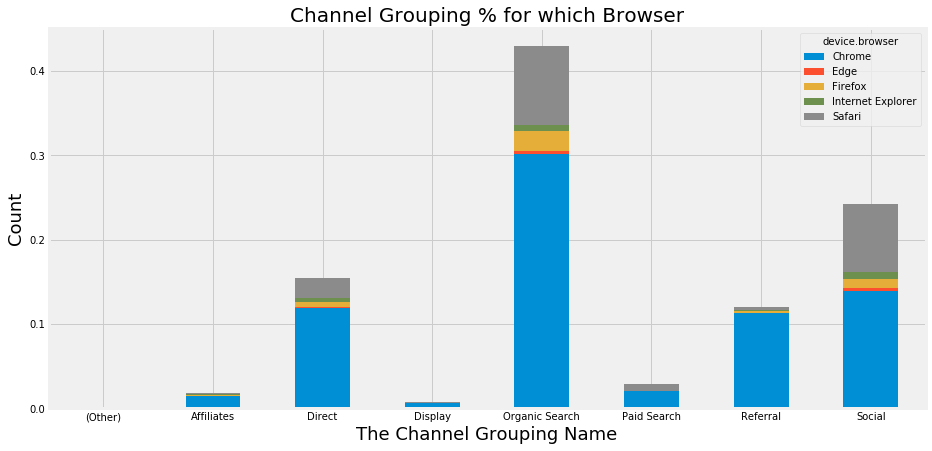

In [113]:
crosstab_eda = pd.crosstab(index=df_train['channelGrouping'], normalize=True, 
                          columns = df_train[df_train['device.browser'].isin(df_train['device.browser'].value_counts()[:5].index.values)]['device.browser'])
crosstab_eda.plot(kind='bar', figsize=(14,7), stacked=True)
plt.title('Channel Grouping % for which Browser', fontsize=20)
plt.xlabel('The Channel Grouping Name', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=0)
plt.show()

In [114]:
crosstab_eda

device.browser,Chrome,Edge,Firefox,Internet Explorer,Safari
channelGrouping,,,,,
(Other),0.000149,0.000000,0.000000,0.000000,0.000000
Affiliates,0.014607,0.000380,0.001289,0.000562,0.001289
Direct,0.118523,0.001421,0.006015,0.005337,0.023199
Display,0.006262,0.000050,0.000281,0.000083,0.001008
Organic Search,0.300810,0.004560,0.022852,0.007683,0.093589
Paid Search,0.020010,0.000149,0.000644,0.000165,0.007336
Referral,0.112673,0.000430,0.002280,0.000661,0.003800
Social,0.138483,0.004263,0.009964,0.008394,0.080800


In [115]:
0.138 + 0.1126 + 0.02 + 0.300 + 0.006 + 0.118 + 0.014 + 0.000149

0.708749